In [1]:
import pandas as pd
import numpy as np
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 200)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import os
os.environ['R_HOME'] = '/root/miniconda3/envs/R/lib/R'

import rpy2.robjects as objects
from rpy2.robjects.packages import importr
base = importr('base')
r_pROC = importr("pROC")
base._libPaths()[0]

def df_stats(df):
    from tabulate import tabulate
    print("\n***** Shape: ", df.shape," *****\n")
    
    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()
    
    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=['Name', 'Null', 'Unique', 'Dtypes'])
    print(tabulate(df_stat_val, headers='keys', tablefmt='psql'))
    return df.head()


In [2]:
### List all files in '/media/data1/muse_ge/ecg_retrospective' ending in XML and add them to list
import glob
import os

## Get all fins in directory 'media/data1/muse_ge/ecg_retrospective' ending in .XML
path = '/media/data1/muse_ge/ecg_retrospective'
all_files = glob.glob(os.path.join(path, "*.xml"))

In [3]:
### Create dataframe with all ECG files
df = pd.DataFrame(all_files, columns=['path'])
display(df)

,path
0,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143132_57000.xml
1,/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120344_07000.xml
2,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143134_90000.xml
3,/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120345_21000.xml
4,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143133_74000.xml
...,...
235528,/media/data1/muse_ge/ecg_retrospective/MUSE_20220930_140325_26000.xml
235529,/media/data1/muse_ge/ecg_retrospective/MUSE_20220930_140326_51000.xml
235530,/media/data1/muse_ge/ecg_retrospective/MUSE_20220930_150535_59000.xml
235531,/media/data1/muse_ge/ecg_retrospective/MUSE_20220930_150550_84000.xml


In [30]:
#this is muse_xml_to_array.py
#Input a directory of XML files, get a directory of np arrays where each .npy is a 12-lead ecg shape 2500,12,1. So this gives you JUST the waveforms
#Some notes, the unique ECG ID index key used in MUSE backend does not exist in the XML at least for us, so instead we use MRN_AcquisitionDTTM_PharmaUniqueECGID

#In terminal run python3 muse_xml_to_array.py <LOCATION_OF_XML_FILES>

import pandas as pd 
import numpy as np 
import xmltodict
import base64
import struct
import argparse
import os
import sys



def file_path(path):
    filepath = path
    for dirName, subdirList, fileList in os.walk(filepath):
        for filename in fileList:
            if ".xml" in filename.lower():
                ekg_file_list.append(os.path.join(dirName, filename))
    
#need to update this function to check the output directory for the output file and then only on newly added EKGs
#add timestamp to start file string 
#this is annoying because the XML file name is a random timestamp and the output file is the UniqueECGID


if not os.path.exists(os.getcwd() + '/ekg_waveforms_output/'):
    os.mkdir(os.getcwd() + '/ekg_waveforms_output/')

# parser = argparse.ArgumentParser(description='Input and outputs for XML EKG parsing')
# parser.add_argument('input', type=str)
# parser.set_defaults(output=os.getcwd() + '/ekg_waveforms_output/') #ensure this directory already exists

# args = parser.parse_args()



def decode_ekg_muse(raw_wave):
    """
    Ingest the base64 encoded waveforms and transform to numeric
    """
    # covert the waveform from base64 to byte array
    arr = base64.b64decode(bytes(raw_wave, 'utf-8'))

    # unpack every 2 bytes, little endian (16 bit encoding)
    unpack_symbols = ''.join([char*int(len(arr)/2) for char in 'h'])
    byte_array = struct.unpack(unpack_symbols,  arr)
    return byte_array


def decode_ekg_muse_to_array(raw_wave, downsample = 1):
    """
    Ingest the base64 encoded waveforms and transform to numeric

    downsample: 0.5 takes every other value in the array. Muse samples at 500/s and the sample model requires 250/s. So take every other.
    """
    try:
        dwnsmpl = int(1//downsample)
    except ZeroDivisionError:
        print("You must downsample by more than 0")
    # covert the waveform from base64 to byte array
    arr = base64.b64decode(bytes(raw_wave, 'utf-8'))

    # unpack every 2 bytes, little endian (16 bit encoding)
    unpack_symbols = ''.join([char*int(len(arr)/2) for char in 'h'])
    byte_array = struct.unpack(unpack_symbols,  arr)
    return np.array(byte_array)[::dwnsmpl]



def xml_to_np_array_file(path_to_xml, path_to_output = os.getcwd()):

    with open(path_to_xml, 'rb') as fd:
        dic = xmltodict.parse(fd.read().decode('utf8'))

    """
    
    Upload the ECG as numpy array with shape=[2500,12,1] ([time, leads, 1]).

    The voltage unit should be in 1 mv/unit and the sampling rate should be 250/second (total 10 second).

    The leads should be ordered as follow I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6.

    """
    #print(dic)
    try:
        pt_id = dic['RestingECG']['PatientDemographics']['PatientID']
    except:
        print("no PatientID")
        pt_id = "none"
    try:
        AcquisitionDateTime = dic['RestingECG']['TestDemographics']['AcquisitionDate'] + "_" + dic['RestingECG']['TestDemographics']['AcquisitionTime'].replace(":","-")
    except:
        print("no AcquisitionDateTime")
        AcquisitionDateTime = "none"    
        

    # try:
    #     requisition_number = dic['RestingECG']['Order']['RequisitionNumber']
    # except:
    #     print("no requisition_number")
    #     requisition_number = "none"

    #need to instantiate leads in the proper order for the model
    lead_order = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    """
    Each EKG will have this data structure:
    lead_data = {
        'I': np.array
    }
    """

    lead_data =  dict.fromkeys(lead_order)
    #lead_data = {leadid: None for k in lead_order}

#     for all_lead_data in dic['RestingECG']['Waveform']:
#         for single_lead_data in lead['LeadData']:
#             leadname =  single_lead_data['LeadID']
#             if leadname in (lead_order):
    try:
        for lead in dic['RestingECG']['Waveform']:
            for leadid in range(len(lead['LeadData'])):
                    sample_length = len(decode_ekg_muse_to_array(lead['LeadData'][leadid]['WaveFormData']))
                    #sample_length is equivalent to dic['RestingECG']['Waveform']['LeadData']['LeadSampleCountTotal']
                    if sample_length == 5000:
                        lead_data[lead['LeadData'][leadid]['LeadID']] = decode_ekg_muse_to_array(lead['LeadData'][leadid]['WaveFormData'], downsample = 0.5)
                    elif sample_length == 2500:
                        lead_data[lead['LeadData'][leadid]['LeadID']] = decode_ekg_muse_to_array(lead['LeadData'][leadid]['WaveFormData'], downsample = 1)
                    else:
                        continue
                #ensures all leads have 2500 samples and also passes over the 3 second waveform

        lead_data['III'] = (np.array(lead_data["II"]) - np.array(lead_data["I"]))
        lead_data['aVR'] = -(np.array(lead_data["I"]) + np.array(lead_data["II"]))/2
        lead_data['aVF'] = (np.array(lead_data["II"]) + np.array(lead_data["III"]))/2
        lead_data['aVL'] = (np.array(lead_data["I"]) - np.array(lead_data["III"]))/2
        
        lead_data = {k: lead_data[k] for k in lead_order}
        # drops V3R, V4R, and V7 if it was a 15-lead ECG

        # now construct and reshape the array
        # converting the dictionary to an np.array
        temp = []
        for key,value in lead_data.items():
            temp.append(value)

        #transpose to be [time, leads, ]
        ekg_array = np.array(temp).T

        #expand dims to [time, leads, 1]
        ekg_array = np.expand_dims(ekg_array,  axis=-1)

        # Here is a check to make sure all the model inputs are the right shape
    #     assert ekg_array.shape == (2500, 12, 1), "ekg_array is shape {} not (2500, 12, 1)".format(ekg_array.shape )

        # filename = '/ekg_waveform_{}_{}.npy'.format(pt_id, requisition_number)
        filename = '{}_{}.npy'.format(pt_id, AcquisitionDateTime)

        path_to_output += filename
        # print(path_to_output)
        with open(path_to_output, 'wb') as f:
            np.save(f, ekg_array)
        return path_to_output
         
    except:
        print("error", dic)
        return None
        

def ekg_batch_run(ekg_list):
    i = 0
    x = 0
    for file in ekg_list:
        try:
            xml_to_np_array_file(file, output_dir)
            i+=1
        except Exception as e:
            # print("file failed: ", file)
            print(file, e)
            x+=1
        if i % 10000 == 0:
            print(f"Succesfully converted {i} EKGs, failed converting {x} EKGs")

            


In [31]:
output_dir = os.getcwd() + '/ekg_waveforms_output/'

from ECGXMLReader import ECGXMLReader
from tqdm import tqdm   
patientid_list = []
patientage_list = []
patient_date_of_birth_list = []
patient_gender_list = []
patient_VentricularRate_list = []
patient_AtrialRate_list = []
patient_PRInterval_list = []
patient_QRSDuration_list = []
patient_QTInterval_list = []
patient_QTCorrected_list = []
patient_Paxis_list = []
patient_Raxis_list = []
patient_TAxis_list = []
patient_QRSCount_list = []
patient_QOnset_list = []
patient_QOffset_list = []
patient_POnset_list = []
patient_POffset_list = []
patient_TOffset_list = []
patient_ECGSampleBase_list = []
patient_ECGSampleExponent_list = []
patient_QTcFrederica_list = []
patient_Location_list = []
patient_LocatioName_list = []
patient_RoomID_list = []
patient_acquisitiondate_list = []
patient_acquisitiontime_list = []
patient_status_list = []
patient_acquisitiondevice_list = []
patient_referringMDLastName_list = []
patient_AnalysisSoftware_list = []
patient_acquisitionSoftwareVersion_list = []
diagnosis_list = []
original_diagnosis_list = []
ecg_output_path_list = []
xml_path_list = []

for index, row in tqdm(df[1:1000].iterrows()):

    ecg = ECGXMLReader(row['path'], augmentLeads=True)
    xml_path_list.append(row['path'])
    ### Concatenate dictionary keys self.ECG['RestingECG']['Diagnosis'] into a list
    patientid_list.append(ecg.PatientDemographics['PatientID'])

    try:
        patientage_list.append(ecg.PatientDemographics['PatientAge'])
    except:
        patientage_list.append(np.nan)
        
    try:
        patient_date_of_birth_list.append(ecg.PatientDemographics['DateofBirth'])
    except:
        patient_date_of_birth_list.append(np.nan)
    try:
        patient_gender_list.append(ecg.PatientDemographics['Gender'])   
    except:
        patient_gender_list.append(np.nan)
        

    try:
        patient_VentricularRate_list.append(ecg.RestingECGMeasurements['VentricularRate'])
    except:
        patient_VentricularRate_list.append(np.nan)
        
    try:
        patient_AtrialRate_list.append(ecg.RestingECGMeasurements['AtrialRate'])
    except:
        patient_AtrialRate_list.append(np.nan)
    try:
        patient_PRInterval_list.append(ecg.RestingECGMeasurements['PRInterval'])
    except:
        patient_PRInterval_list.append(np.nan) 
    try: 
        patient_QRSDuration_list.append(ecg.RestingECGMeasurements['QRSDuration'])
    except:
        patient_QRSDuration_list.append(np.nan)
    try:    
        patient_QTInterval_list.append(ecg.RestingECGMeasurements['QTInterval'])
    except:
        patient_QTInterval_list.append(np.nan)

    try:   
        patient_QTCorrected_list.append(ecg.RestingECGMeasurements['QTCorrected'])
    except:
        patient_QTCorrected_list.append(np.nan)
    try:
        patient_Paxis_list.append(ecg.RestingECGMeasurements['PAxis'])
    except:
        patient_Paxis_list.append(np.nan)

    try:
        patient_Raxis_list.append(ecg.RestingECGMeasurements['RAxis'])
    except:
        patient_Raxis_list.append(np.nan)
    try:
        patient_TAxis_list.append(ecg.RestingECGMeasurements['TAxis'])
    except:
        patient_TAxis_list.append(np.nan)
        
    try:
        patient_QRSCount_list.append(ecg.RestingECGMeasurements['QRSCount'])
    except:
        patient_QRSCount_list.append(np.nan)
    try:
        patient_QOnset_list.append(ecg.RestingECGMeasurements['QOnset'])
    except:
        patient_QOnset_list.append(np.nan)
        
    try:
        patient_QOffset_list.append(ecg.RestingECGMeasurements['QOffset'])
    except:
        patient_QOffset_list.append(np.nan)
    try:
        patient_POnset_list.append(ecg.RestingECGMeasurements['POnset'])
    except:
        patient_POnset_list.append(np.nan)
    try:
        patient_POffset_list.append(ecg.RestingECGMeasurements['POffset'])
    except:
        patient_POffset_list.append(np.nan)
    try:
        patient_TOffset_list.append(ecg.RestingECGMeasurements['TOffset'])
    except:
        patient_TOffset_list.append(np.nan)
        
    patient_ECGSampleBase_list.append(ecg.RestingECGMeasurements['ECGSampleBase'])
    patient_ECGSampleExponent_list.append(ecg.RestingECGMeasurements['ECGSampleExponent'])
    try:
        patient_QTcFrederica_list.append(ecg.RestingECGMeasurements['QTcFrederica'])
    except:
        patient_QTcFrederica_list.append(np.nan)

        
    patient_Location_list.append(ecg.TestDemographics['Location'])

    try:
        patient_LocatioName_list.append(ecg.TestDemographics['LocationName'])
    except:
        patient_LocatioName_list.append(np.nan)

        
    try:
        patient_RoomID_list.append(ecg.TestDemographics['RoomID'])
    except:
        patient_RoomID_list.append('None')
    try:
        patient_acquisitiondate_list.append(ecg.TestDemographics['AcquisitionDate'])
    except:
        patient_acquisitiondate_list.append(np.nan)

    try:
        patient_acquisitiontime_list.append(ecg.TestDemographics['AcquisitionTime'])
    except:
        patient_acquisitiontime_list.append(np.nan)

    patient_status_list.append(ecg.TestDemographics['Status'])

    try:
        patient_acquisitiondevice_list.append(ecg.TestDemographics['AcquisitionDevice'])
    except:
        patient_acquisitiondevice_list.append(np.nan)
        
    try:
        patient_referringMDLastName_list.append(ecg.TestDemographics['ReferringMDLastName'])
    except:
        patient_referringMDLastName_list.append('None')
    try:
        patient_AnalysisSoftware_list.append(ecg.TestDemographics['AnalysisSoftwareVersion'])
    except:
        patient_AnalysisSoftware_list.append(np.nan)
    try:
        patient_acquisitionSoftwareVersion_list.append(ecg.TestDemographics['AcquisitionSoftwareVersion'])
    except:
        patient_acquisitionSoftwareVersion_list.append(np.nan)
        

    diagnosis = []
    try:
        for key in ecg.Diagnosis['DiagnosisStatement']:
            #print(key['StmtText'])
            try:
                diagnosis.append(key['StmtText'])
            except:
                diagnosis.append(key['ENDSLINE'])

        ##merge items in diagnosis list into a single string
        diagnosis = ' '.join(diagnosis)

        diagnosis_list.append(diagnosis)
    except:
        print(ecg.TestDemographics)
        print(ecg.PatientDemographics)
        print(ecg.RestingECGMeasurements)
        print(ecg.PatientDemographics['PatientID'])
        diagnosis_list.append(-1)
    
    diagnosis = []
    try:
        for key in ecg.OriginalDiagnosis['DiagnosisStatement']:
            #print(key['StmtText'])
            try:
                diagnosis.append(key['StmtText'])
            except:
                diagnosis.append(key['ENDSLINE'])

        ##merge items in diagnosis list into a single string
        diagnosis = ' '.join(diagnosis)

        original_diagnosis_list.append(diagnosis)
    except:
        print(ecg.TestDemographics)
        print(ecg.PatientDemographics)
        print(ecg.RestingECGMeasurements)
        print(ecg.PatientDemographics['PatientID'])
        original_diagnosis_list.append(-1)

        #display(ecg.Diagnosis['DiagnosisStatement'])
        #break
    #print(ecg.TestDemographics)
    #print(ecg.PatientDemographics)
    #print(ecg.RestingECGMeasurements)
    #print(ecg.Diagnosis)
    #print(ecg.OriginalDiagnosis)
    ecg_output_path = xml_to_np_array_file(row['path'],output_dir)
    ecg_output_path_list.append(ecg_output_path)
##Create dataaframe with the previous lists
df_output = pd.DataFrame({'patientid':patientid_list,'age':patientage_list,'dob':patient_date_of_birth_list,'gender':patient_gender_list,'VentricularRate':patient_VentricularRate_list,'AtrialRate':patient_AtrialRate_list,
                          'PRInterval':patient_PRInterval_list,'QRSDuration':patient_QRSDuration_list,'QTInterval':patient_QTInterval_list,'QTCorrected':patient_QTCorrected_list,
                            'PAxis':patient_Paxis_list,'RAXis':patient_Raxis_list,'TAxis':patient_TAxis_list,'QRSCount':patient_QRSCount_list,'QOnset':patient_QOnset_list,'QOffset':patient_QOffset_list,'POnset':patient_POnset_list,
                            'POffset':patient_POffset_list,'TOffset':patient_TOffset_list,'ECGSampleBase':patient_ECGSampleBase_list,'ECGSampleExponent':patient_ECGSampleExponent_list,'QTcFrederica':patient_QTcFrederica_list,
                            'Location':patient_Location_list,'LocationName':patient_LocatioName_list,'RoomID':patient_RoomID_list,'AcquisitionDate':patient_acquisitiondate_list,'AcquisitionTime':patient_acquisitiontime_list,'Status':patient_status_list,
                            'AcquisitionDevice':patient_acquisitiondevice_list,'ReferringMDLastName':patient_referringMDLastName_list,'AnalysisSoftware':patient_AnalysisSoftware_list,'AcquisitionSoftwareVersion':patient_acquisitionSoftwareVersion_list,
                            'Diagnosis':diagnosis_list,'Original_Diagnosis':original_diagnosis_list, 'xml_path':xml_path_list, 'ecg_output_path':ecg_output_path_list})


6it [00:00, 52.19it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
{'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'MV360', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '14:15:00', 'AcquisitionDate': '08-19-2021', 'CartNumber': '0', 'AcquisitionSoftwareVersion': '1.02 SP01', 'AnalysisSoftwareVersion': '243', 'EditTime': '14:22:12', 'EditDate': '08-19-2021', 'OverreaderID': '6666', 'EditorID': '4846', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}
{'PatientID': '0799999', 'PatientAge': '81', 'AgeUn

20it [00:00, 56.91it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


33it [00:00, 57.91it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


47it [00:00, 62.05it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
'Waveform'
{'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '14:30:57', 'AcquisitionDate': '11-01-2021', 'EditTime': '10:57:44', 'EditDate': '11-02-2021', 'OverreaderID': '20001', 'EditorID': '4846', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'MuseAdmin', 'OverreaderFirstName': 'MuseAdmin', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}
{'PatientID': '0799999', 'PatientAge': '81', 'AgeUnits': 'YEARS', 'Date

59it [00:01, 57.69it/s]

list indices must be integers or slices, not str
{'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'MV360', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '1', 'LocationName': '1_CARDIOLOGIE GENERALE', 'AcquisitionTime': '09:52:53', 'AcquisitionDate': '06-01-2022', 'CartNumber': '1', 'AcquisitionSoftwareVersion': '1.02 SP02', 'AnalysisSoftwareVersion': '243', 'EditTime': '10:27:14', 'EditDate': '06-01-2022', 'OverreaderID': '6666', 'EditorID': '4846', 'OrderingMDLastName': 'Md I.C.M.', 'OrderingMDFirstName': 'A Confirmer', 'ReferringMDLastName': 'Md I.C.M.', 'ReferringMDFirstName': 'A Confirmer', 'OverreaderLastName': 'NON VALIDÉ', 'OverreaderFirstName': 'PRELIMINAIRE', 'EditorLastName': 'PELLERIN', 'EditorFirstName': 'SANDRA', 'HISStatus': '2'}
{'PatientID': '0799999', 'PatientAge': '81', 'AgeUnits': 'YEARS', 'DateofBirth': '06-21-1940', 'Gender': 'MALE', 'PatientLastName': 'MEDISOL', 'Patie

71it [00:01, 57.89it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
{'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'MV360', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '21', 'LocationName': '21_URGENCE AMBULATOIRE', 'AcquisitionTime': '10:21:25', 'AcquisitionDate': '06-20-2022', 'CartNumber': '8', 'AcquisitionSoftwareVersion': '1.02 SP02', 'AnalysisSoftwareVersion': '243', 'EditTime': '11:03:57', 'EditDate': '06-20-2022', 'OverreaderID': '11073', 'AcquisitionTechID': '9892', 'EditorID': '11073', 'TestReason': 'UE', 'OrderingMDLastName': 'Urgentologue', 'OrderingMDFirstName': 'ICM', 'ReferringMDLastName': 'Urgentologue', 'ReferringMDFirstName': 'ICM', 'OverreaderLastName': 'LISZKOWSKI, MD', 'OverreaderFirstName': 'MARK', 'AcquisitionTechLastName': 'CHUIDO', 'Acq

85it [00:01, 59.65it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


99it [00:01, 60.39it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


106it [00:01, 59.70it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


120it [00:02, 57.72it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


132it [00:02, 55.20it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


144it [00:02, 56.83it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


156it [00:02, 53.29it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


162it [00:02, 52.07it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


176it [00:03, 55.90it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


188it [00:03, 53.68it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


200it [00:03, 55.16it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


212it [00:03, 55.64it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


224it [00:03, 51.92it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


236it [00:04, 52.01it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


248it [00:04, 54.37it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


260it [00:04, 56.72it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


272it [00:04, 57.70it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


284it [00:05, 57.31it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


296it [00:05, 58.16it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


309it [00:05, 58.95it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


321it [00:05, 56.17it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


334it [00:05, 54.67it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


340it [00:06, 54.71it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


352it [00:06, 55.59it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


364it [00:06, 55.13it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


377it [00:06, 55.46it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


389it [00:06, 54.83it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


401it [00:07, 56.88it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


413it [00:07, 55.66it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


425it [00:07, 56.87it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


437it [00:07, 57.98it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


449it [00:07, 57.95it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


461it [00:08, 58.34it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


473it [00:08, 58.43it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


485it [00:08, 58.50it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


497it [00:08, 54.77it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


509it [00:09, 53.53it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


521it [00:09, 54.44it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


527it [00:09, 55.82it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


539it [00:09, 49.58it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


551it [00:09, 52.36it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


557it [00:09, 51.59it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


570it [00:10, 54.13it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


583it [00:10, 54.88it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


597it [00:10, 56.09it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


610it [00:10, 58.65it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


623it [00:11, 57.85it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


635it [00:11, 57.71it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


641it [00:11, 57.26it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


654it [00:11, 54.79it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


667it [00:11, 55.54it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


680it [00:12, 55.62it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


692it [00:12, 55.62it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


704it [00:12, 55.22it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


717it [00:12, 57.80it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


730it [00:13, 58.42it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


742it [00:13, 58.87it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


755it [00:13, 58.81it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


768it [00:13, 58.75it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


781it [00:13, 59.23it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


793it [00:14, 58.10it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


800it [00:14, 59.42it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
{'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'MV360', 'Status': 'CONFIRMED', 'EditListStatus': 'Confirmed', 'Priority': 'NORMAL', 'Location': '22', 'LocationName': '22_URGENCE MAJEURE', 'RoomID': 'A10', 'AcquisitionTime': '22:03:23', 'AcquisitionDate': '06-17-2022', 'CartNumber': '10', 'AcquisitionSoftwareVersion': '1.02 SP02', 'AnalysisSoftwareVersion': '243', 'EditTime': '10:19:39', 'EditDate': '06-20-2022', 'OverreaderID': '11073', 'Acquisition

813it [00:14, 57.80it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


825it [00:14, 57.53it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


837it [00:14, 57.41it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


850it [00:15, 57.63it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


863it [00:15, 57.94it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


875it [00:15, 57.25it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


888it [00:15, 58.69it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


902it [00:15, 59.76it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


915it [00:16, 60.26it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


928it [00:16, 57.63it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


942it [00:16, 59.57it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


949it [00:16, 59.87it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


963it [00:16, 58.04it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


975it [00:17, 54.99it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


988it [00:17, 57.08it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


999it [00:17, 56.60it/s]

list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


In [32]:
df_m = df_output.groupby(['patientid','AcquisitionDate','AcquisitionTime']).first().reset_index()
display(df_stats(df_output))
display(df_stats(df_m))
## The ECGs can be grouped by patient id, date and time to have a 1 unique row per ECG - this means the filename to save the ECG also needs to have the date and time in it.



***** Shape:  (999, 36)  *****

+----+----------------------------+--------+----------+----------+
|    | Name                       |   Null |   Unique | Dtypes   |
|----+----------------------------+--------+----------+----------|
|  0 | patientid                  |      0 |      670 | object   |
|  1 | age                        |      0 |       70 | object   |
|  2 | dob                        |      3 |      662 | object   |
|  3 | gender                     |      0 |        2 | object   |
|  4 | VentricularRate            |      1 |      100 | object   |
|  5 | AtrialRate                 |    152 |      113 | object   |
|  6 | PRInterval                 |    228 |      107 | object   |
|  7 | QRSDuration                |      1 |       81 | object   |
|  8 | QTInterval                 |      1 |      139 | object   |
|  9 | QTCorrected                |      1 |      184 | object   |
| 10 | PAxis                      |    236 |      129 | object   |
| 11 | RAXis                 

,patientid,age,dob,gender,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAXis,TAxis,QRSCount,QOnset,QOffset,POnset,POffset,TOffset,ECGSampleBase,ECGSampleExponent,QTcFrederica,Location,LocationName,RoomID,AcquisitionDate,AcquisitionTime,Status,AcquisitionDevice,ReferringMDLastName,AnalysisSoftware,AcquisitionSoftwareVersion,Diagnosis,Original_Diagnosis,xml_path,ecg_output_path
0,0799999,81,06-21-1940,MALE,60,60,164,82,382,382,44,46,47,9,220,261,138,181,411,500,0,382,1,1_CARDIOLOGIE GENERALE,None,08-13-2021,11:01:03,CONFIRMED,MV360,Md I.C.M.,243,1.02 SP01,"Rythme sinusal normal Rapport R/S augmenté en V1, considérer rotation horaire ou infarctus postérieur ECG anormal","Rythme sinusal normal Rapport R/S augmenté en V1, considérer rotation horaire ou infarctus postérieur ECG anormal",/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120344_07000.xml,/volume/DeepECG/ekg_waveforms_output/0799999_08-13-2021_11-01-03.npy
1,0609146,38,09-30-1983,MALE,185,NaN,NaN,78,266,466,NaN,145,20,31,216,255,NaN,NaN,349,500,0,387,43,4 NORD,456,06-22-2022,21:20:00,UNCONFIRMED,MV360,None,243,1.02 SP02,*** ATTENTION! mauvaise qualité de l'ECG*** Tachycardie supraventriculaire Hypertrophie ventriculaire droite ECG anormal,*** ATTENTION! mauvaise qualité de l'ECG*** Tachycardie supraventriculaire Hypertrophie ventriculaire droite ECG anormal,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143134_90000.xml,/volume/DeepECG/ekg_waveforms_output/0609146_06-22-2022_21-20-00.npy
2,0799999,81,06-21-1940,MALE,0,0,NaN,0,0,0,0,0,0,0,0,0,NaN,NaN,0,500,0,0,1,1_CARDIOLOGIE GENERALE,None,08-19-2021,14:15:00,CONFIRMED,MV360,Md I.C.M.,243,1.02 SP01,-1,-1,/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120345_21000.xml,/volume/DeepECG/ekg_waveforms_output/0799999_08-19-2021_14-15-00.npy
3,0609083,66,07-05-1955,MALE,53,53,172,148,452,424,54,-48,61,8,211,285,125,171,437,500,0,433,51,5 COURT-SEJOUR,502-5,06-22-2022,22:51:54,UNCONFIRMED,MV360,None,243,1.02 SP02,Bradycardie sinusale Bloc de branche droit complet Hémibloc antérieur gauche *** Bloc bifasiculaire *** ECG anormal,Bradycardie sinusale Bloc de branche droit complet Hémibloc antérieur gauche *** Bloc bifasiculaire *** ECG anormal,/media/data1/muse_ge/ecg_retrospective/MUSE_20220712_143133_74000.xml,/volume/DeepECG/ekg_waveforms_output/0609083_06-22-2022_22-51-54.npy
4,0799999,81,06-21-1940,MALE,60,NaN,118,46,420,420,51,48,50,NaN,NaN,NaN,NaN,NaN,NaN,500,0,420,0,0_DEFAULT,None,09-01-2021,10:07:59,CONFIRMED,Datam,None,NO SERIAL,NO SERIAL,"*** DEMO LICENSE - NOT VALID FOR PRODUCTION USE *** *** IM AIGU/ISCHÃ?MIE *** Rythme sinusal Anomalie diffuse du segment ST-T, aspect de lÃ©sion/ischÃ©mie myocardique ECG anormal *** DEMO LICENSE ...","*** DEMO LICENSE - NOT VALID FOR PRODUCTION USE *** *** IM AIGU/ISCHÃ?MIE *** Rythme sinusal Anomalie diffuse du segment ST-T, aspect de lÃ©sion/ischÃ©mie myocardique ECG anormal *** DEMO LICENSE ...",/media/data1/muse_ge/ecg_retrospective/MUSE_20220622_120346_40000.xml,/volume/DeepECG/ekg_waveforms_output/0799999_09-01-2021_10-07-59.npy



***** Shape:  (999, 36)  *****

+----+----------------------------+--------+----------+----------+
|    | Name                       |   Null |   Unique | Dtypes   |
|----+----------------------------+--------+----------+----------|
|  0 | patientid                  |      0 |      670 | object   |
|  1 | AcquisitionDate            |      0 |       19 | object   |
|  2 | AcquisitionTime            |      0 |      986 | object   |
|  3 | age                        |      0 |       70 | object   |
|  4 | dob                        |      3 |      662 | object   |
|  5 | gender                     |      0 |        2 | object   |
|  6 | VentricularRate            |      1 |      100 | object   |
|  7 | AtrialRate                 |    152 |      113 | object   |
|  8 | PRInterval                 |    228 |      107 | object   |
|  9 | QRSDuration                |      1 |       81 | object   |
| 10 | QTInterval                 |      1 |      139 | object   |
| 11 | QTCorrected           

,patientid,AcquisitionDate,AcquisitionTime,age,dob,gender,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAXis,TAxis,QRSCount,QOnset,QOffset,POnset,POffset,TOffset,ECGSampleBase,ECGSampleExponent,QTcFrederica,Location,LocationName,RoomID,Status,AcquisitionDevice,ReferringMDLastName,AnalysisSoftware,AcquisitionSoftwareVersion,Diagnosis,Original_Diagnosis,xml_path,ecg_output_path
0,0001683,06-17-2022,13:08:12,76,01-15-1946,MALE,56,56,194,98,404,389,35,-37,10,9,224,273,127,199,426,500,0,395,21,21_URGENCE AMBULATOIRE,None,CONFIRMED,MV360,Urgentologue,243,1.02 SP02,Bradycardie sinusale Déviation axiale gauche ECG anormal,Bradycardie sinusale Déviation axiale gauche ECG anormal,/media/data1/muse_ge/ecg_retrospective/MUSE_20220816_100801_21000.xml,/volume/DeepECG/ekg_waveforms_output/0001683_06-17-2022_13-08-12.npy
1,0003599,06-22-2022,09:32:40,74,02-28-1948,MALE,54,54,392,98,404,383,-3,29,47,9,215,264,None,None,417,500,0,389,21,21_URGENCE AMBULATOIRE,None,CONFIRMED,MV360,Urgentologue,243,1.02 SP02,Bradycardie sinusale avec bloc A-V du premier degré ECG normal par ailleurs,Bradycardie sinusale avec bloc A-V du premier degré ECG normal par ailleurs,/media/data1/muse_ge/ecg_retrospective/MUSE_20220816_100759_81000.xml,/volume/DeepECG/ekg_waveforms_output/0003599_06-22-2022_09-32-40.npy
2,0004866,06-21-2022,10:01:28,84,03-03-1938,MALE,58,58,192,90,420,412,83,62,81,9,218,263,122,175,428,500,0,415,21,21_URGENCE AMBULATOIRE,None,CONFIRMED,MV360,Urgentologue,243,1.02 SP02,Bradycardie sinusale ECG normal par ailleurs,Bradycardie sinusale ECG normal par ailleurs,/media/data1/muse_ge/ecg_retrospective/MUSE_20220816_100802_56000.xml,/volume/DeepECG/ekg_waveforms_output/0004866_06-21-2022_10-01-28.npy
3,0006147,06-17-2022,15:28:05,83,07-11-1938,FEMALE,90,220,None,90,378,462,None,21,29,15,221,266,None,None,410,500,0,432,21,21_URGENCE AMBULATOIRE,UE,CONFIRMED,MV360,Urgentologue,243,1.02 SP02,Flutter auriculaire avec bloc A-V variable ECG anormal,Flutter auriculaire avec bloc A-V variable ECG anormal,/media/data1/muse_ge/ecg_retrospective/MUSE_20220816_100803_81000.xml,/volume/DeepECG/ekg_waveforms_output/0006147_06-17-2022_15-28-05.npy
4,0006147,06-18-2022,09:40:57,83,07-11-1938,FEMALE,103,220,None,90,372,487,None,166,148,17,213,258,None,None,399,500,0,445,22,22_URGENCE MAJEURE,A4,CONFIRMED,MV360,None,243,1.02 SP02,Flutter auriculaire avec bloc A-V variable Déviation axiale droite ECG anormal,Flutter auriculaire avec bloc A-V variable Déviation axiale droite ECG anormal,/media/data1/muse_ge/ecg_retrospective/MUSE_20220816_100805_04000.xml,/volume/DeepECG/ekg_waveforms_output/0006147_06-18-2022_09-40-57.npy


In [9]:
#output_dir = os.getcwd() + '/ekg_waveforms_output/'
#ekg_batch_run(df['path'][0:1])

{'RestingECG': {'MuseInfo': {'MuseVersion': '9.0.10.18530'}, 'PatientDemographics': {'PatientID': '0604777', 'PatientAge': '74', 'AgeUnits': 'YEARS', 'DateofBirth': '07-18-1947', 'Gender': 'MALE', 'PatientLastName': 'HUARD', 'PatientFirstName': 'OCTAVE'}, 'TestDemographics': {'DataType': 'RESTING', 'Site': '1', 'SiteName': 'INSTITUT DE CARDIOLOGIE DE MTL', 'AcquisitionDevice': 'MV360', 'Status': 'UNCONFIRMED', 'EditListStatus': 'Newly Acquired', 'Priority': 'NORMAL', 'Location': '33', 'LocationName': '3 NORD', 'RoomID': '61', 'AcquisitionTime': '21:34:54', 'AcquisitionDate': '06-22-2022', 'CartNumber': '12', 'AcquisitionSoftwareVersion': '1.02 SP02', 'AnalysisSoftwareVersion': '243', 'AcquisitionTechID': '11917', 'EditorID': '13', 'TestReason': 'JOUR 0', 'ReferringMDLastName': 'DR.BOUCHARD', 'AcquisitionTechLastName': 'FAUSTIN', 'AcquisitionTechFirstName': 'MARVRINE', 'HISStatus': '0'}, 'Order': {'ExtraADTData1': '604777'}, 'RestingECGMeasurements': {'VentricularRate': '76', 'AtrialRat

### Display ECG

In [12]:

npyfilespath =os.getcwd() + '/ekg_waveforms_output/'
os.chdir(npyfilespath)
npfiles= glob.glob( "*.npy")
npfiles.sort()
all_arrays_train = []
# all_arrays_eval = []

#If trying to test model quickly use smaller total dataset or change dataloader to load npy file batch by batch

#Not rewriting stacked array so below is commented out

for i, npfile in enumerate(npfiles):
    x = 0
    i = 0
    try:
        path = os.path.join(npyfilespath + npfile)
        file=np.load(path)

        file=np.reshape(file,(1,2500,12))
        all_arrays_train.append(file)
        x += 1
        i += 1
    except:
        continue
    if i % 1 == 100:
        print("{i} EKGs have been written to array")


In [14]:
display(all_arrays_train)

[array([[[ -6.,   2.,   8., ...,  -8.,  -7.,  -6.],
         [ -4.,   2.,   6., ...,  -7.,  -5.,  -6.],
         [ -7.,  -6.,   1., ...,  -6.,  -6.,  -8.],
         ...,
         [ -6.,   3.,   9., ..., -10., -15.,  -7.],
         [ -4.,   5.,   9., ...,  -9., -14.,  -7.],
         [  0.,  10.,  10., ...,  -8., -14.,  -6.]]]),
 array([[[ -6.,  -5.,   1., ...,  -9., -10.,  -7.],
         [ -3.,  -4.,  -1., ..., -10., -10.,  -6.],
         [ -4.,  -3.,   1., ...,  -8.,  -6.,  -5.],
         ...,
         [-11.,  -6.,   5., ..., -13.,  -7.,  -9.],
         [-10.,  -6.,   4., ..., -14.,  -8.,  -9.],
         [ -9.,  -6.,   3., ..., -13.,  -6.,  -8.]]]),
 array([[[  5., -23., -28., ..., -29., -26., -26.],
         [  4., -31., -35., ..., -37., -37., -35.],
         [  1., -37., -38., ..., -38., -39., -37.],
         ...,
         [ -2.,  -5.,  -3., ...,  -8.,  -7.,  -8.],
         [  0.,  -2.,  -2., ...,  -9.,  -7.,  -8.],
         [  1.,  -7.,  -8., ...,  -7.,  -6.,  -7.]]]),
 array([[[ -3

In [18]:
all_arrays_train = np.array(all_arrays_train)
reshaped = np.reshape(all_arrays_train,(all_arrays_train.shape[0],2500,12))

In [ ]:
path = os.path.join(npyfilespath + npfile)
file=np.load(path)

file=np.reshape(file,(1,2500,12))

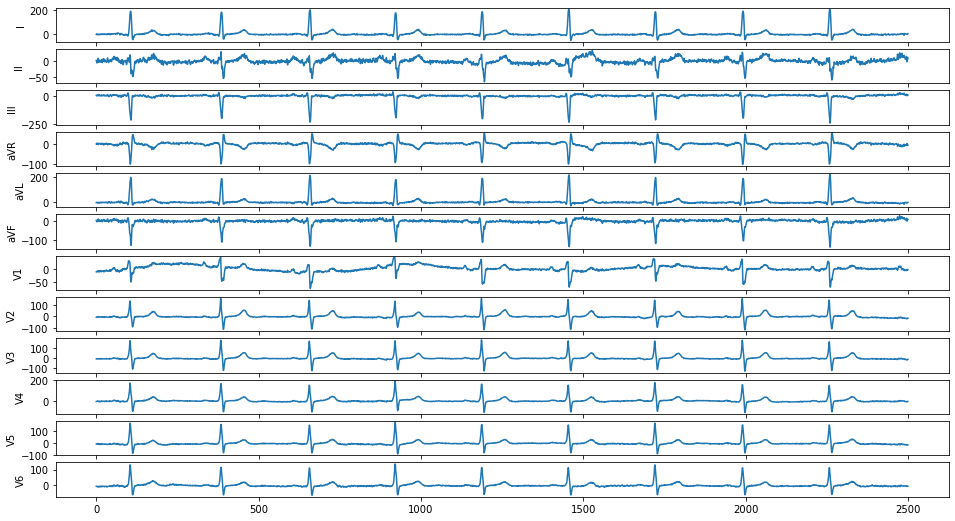

In [25]:
#To reconstruct the 12 lead ecg from the array
lead_order = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
plt.rcParams["figure.figsize"] = [16,9]
fig, axs = plt.subplots(len(lead_order))
for i in range(0,12):
    axs[i].plot(reshaped[0][:,i])
    axs[i].set(ylabel=str(lead_order[i]))

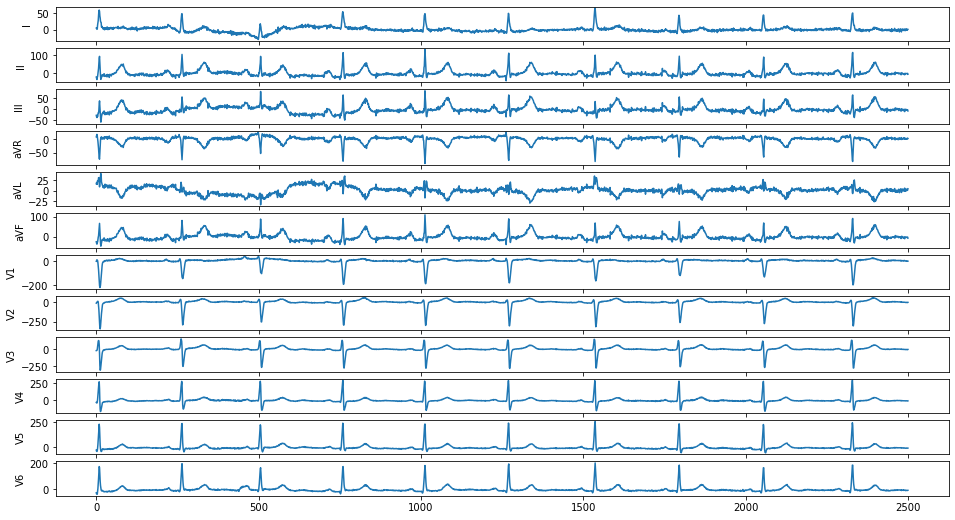

In [27]:
import matplotlib.pyplot as plt
#To reconstruct the 12 lead ecg from the array
lead_order = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
plt.rcParams["figure.figsize"] = [16,9]
fig, axs = plt.subplots(len(lead_order))
for i in range(0,12):
    axs[i].plot(reshaped[2][:,i])
    axs[i].set(ylabel=str(lead_order[i]))